In [ ]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from discretize import TensorMesh
from discretize.utils import ndgrid, mkvc

import simpeg.electromagnetics.time_domain as tdem
from simpeg import maps, data, data_misfit as dm, inverse_problem, regularization as reglib, optimization, directives, inversion


from simpeg.directives import InversionDirective
import tensorflow as tf

from scipy.sparse import csr_matrix, diags
from simpeg.regularization import BaseRegularization
from simpeg import maps
from scipy.sparse import diags, csr_matrix

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [ ]:
# Geometry and time channel settings (same approach as in 2D-TEM-separate.ipynb)
source_current = 1.0

off_time = 0.0
time_channels = np.logspace(-4, -1, 40)
waveform = tdem.sources.StepOffWaveform(off_time=off_time)

# X-direction receiver locations (adjust range and step size as needed)
receiver_locations = ndgrid(
    np.linspace(-200, 200, 24),
    np.array(0),
    [0]
)

# Transmitter loop (example: rectangular loop)
xyz_loop = np.array([
    [-150, -150, 0], [0, -150, 0], [150, -150, 0], [150, 0, 0],
    [150, 150, 0], [0, 150, 0], [-150, 150, 0], [-150, 0, 0], [-150, -150, 0]
])

# Assemble the sources list for the Survey (one LineCurrent source per receiver to collect dBz/dt)
source_list = []
for i in range(receiver_locations.shape[0]):
    src = tdem.sources.LineCurrent(
        receiver_list=[
            tdem.receivers.PointMagneticFluxTimeDerivative(
                receiver_locations[i:i+1, :], time_channels, "z"
            )
        ],
        location=xyz_loop,
        waveform=waveform,
        current=source_current,
    )
    source_list.append(src)

survey_tem = tdem.Survey(source_list)

n_x = receiver_locations.shape[0]
n_time = time_channels.size


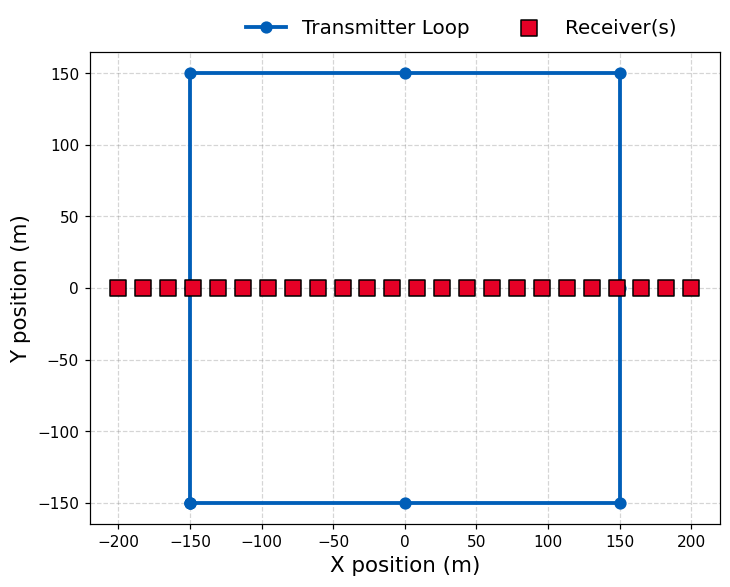

In [ ]:

# Plot the spatial layout of the transmitter loop and receiver points (aesthetically formatted)
fig, ax = plt.subplots(figsize=(7, 7), dpi=110)
xyz_loop_forplot = np.vstack([xyz_loop, xyz_loop[0]])  # Close the transmitter loop for plotting

# Plot the transmitter loop
ax.plot(
    xyz_loop_forplot[:, 0], xyz_loop_forplot[:, 1],
    color="#005eb8", marker="o", markersize=7, linewidth=2.5,
    label="Transmitter Loop"
)

# Plot the receiver points
ax.scatter(
    receiver_locations[:, 0], receiver_locations[:, 1],
    c="#e60026", edgecolor="k", s=120, marker="s", label="Receiver(s)", zorder=5
)

ax.set_xlabel("X position (m)", fontsize=14)
ax.set_ylabel("Y position (m)", fontsize=14)
ax.legend(fontsize=13, frameon=False, shadow=True, loc='center left', bbox_to_anchor=(0.22, 1.05), ncol=2)
ax.grid(True, which="both", ls="--", color="#888888", alpha=0.35)

# Improve display quality and layout
ax.set_aspect('equal', 'box')
fig.tight_layout(pad=2.0)
plt.show()



In [ ]:
res_layer = 32
a, b = 1,10000

# m0 is a half-space model with resistivity 500 Ohm·m
m0_phys = np.full((n_x, res_layer), 200.0)

alpha_s, alpha_x, alpha_z = 1e-2,1.0, 1.0
maxIter, maxIterCG, maxIterLS = 20, 10, 10
rel_noise, noise_floor = 0.03, 0



mesh_lci 维度: nCx = 24 , nCz = 32


TensorMesh: 768 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     24        -12.00         12.00      1.00      1.00    1.00
   y     32       -620.54         -0.00      4.54     47.28    1.08

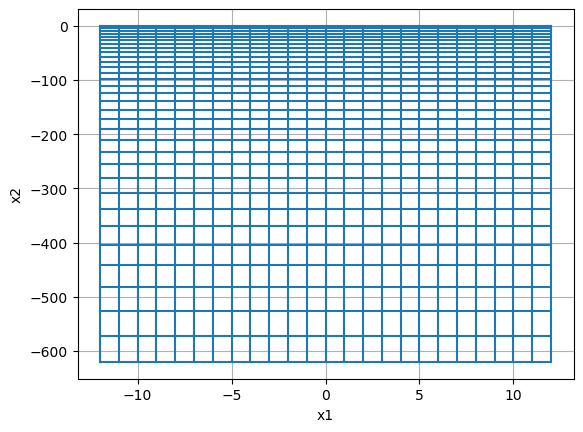

In [ ]:



class DummyForGrid:
    def __init__(self, ny):
        self.ny = ny
        self.y_uniform = np.linspace(0, 600, ny + 1) 
    
    def create_log_depth_grid(self,  z0=1.0, exponent=2.5):
        y_max = self.y_uniform[-1]
        i = np.linspace(0, 1, self.ny + 1)
        z_edges = z0 * (np.exp(exponent * i) - 1)
        z_edges = z_edges / z_edges[-1] * y_max
        z_centers = (z_edges[:-1] + z_edges[1:]) / 2
        return z_centers

dummy = DummyForGrid(res_layer)
depths = dummy.create_log_depth_grid(z0=1.0, exponent=2.5)

thicknesses = np.r_[np.diff(depths)]

hx = np.ones(n_x)
hz = np.r_[np.diff(depths), np.diff(depths)[-1]]

hz = np.flipud(hz)

mesh_lci = TensorMesh([hx, hz], "CN")
reg_map_lci = maps.IdentityMap(nP=mesh_lci.nC)
mesh_lci.plot_grid()

print("mesh_lci : nCx =", mesh_lci.shape_cells[0], ", nCz =", mesh_lci.shape_cells[1])
mesh_lci

In [ ]:
# 2) Initial 2D resistivity model (laterally smoothed) and m0

# 3) Mapping chain and Simulation construction
class NewMap(maps.IdentityMap):
    def __init__(self, a=1.0, b=1000.0):
        super().__init__()
        self.a = float(a)
        self.b = float(b)
    def _transform(self, m):
        # Forward transform from model to physical domain using a scaled sigmoid
        return self.a + (self.b - self.a) / (1.0 + np.exp(-m))
    def deriv(self, m):
        # Derivative of the transform for use in inversion
        m = np.asarray(m).reshape(-1)
        sig = 1.0 / (1.0 + np.exp(-m))
        drho_dm = (self.b - self.a) * sig * (1.0 - sig)
        from scipy.sparse import diags
        return diags(drho_dm, 0, shape=(m.size, m.size), format="csr")
    

sim_list = []
for i in range(n_x):
    # Create a separate survey for each location/index
    survey_i = tdem.Survey([source_list[i]])
    index_i = np.arange(i * res_layer, (i + 1) * res_layer)
    proj_i = maps.Projection(nP=n_x * res_layer, index=index_i)
    rho_map_i = (NewMap(a=a, b=b) * proj_i)
    sim_i = tdem.simulation_1d.Simulation1DLayered(
        survey=survey_i,
        thicknesses=thicknesses,
        rhoMap=rho_map_i,
    )
    sim_list.append(sim_i)

# 4) Data (synthetic)


def logit(x, a=1.0, b=1000.0):
    # Logit transform to map physical values to model values
    x = np.clip(x, a + 1e-8, b - 1e-8)
    return np.log(x - a) - np.log(b - x)


m0_phys = np.full((n_x, res_layer), 200.0)  # Initialize with a constant resistivity
m0 = logit(m0_phys, a=a, b=b).reshape(-1)
# true_rho_2d = np.load("D:\教学\深度学习正则化\拟2DTEM正则化\inversion_model.npy")
true_rho_2d = np.load("D:\教学\深度学习正则化\拟2DTEM正则化\Train\数据集\测试\case_compared/case.npy")

print(true_rho_2d.shape)

m_true_concat = logit(true_rho_2d, a=a, b=b).reshape(-1)


(24, 32)


In [ ]:
class GradientRegularization(BaseRegularization):
    """
    Regularization term based on model gradients.
    """

    def __init__(self, nn_model, mesh, beta=1.0, a=1, b=1000, weights=None, **kwargs):
        """
        mesh: SimPEG mesh object, should provide mesh.shape_cells (n_x, n_layers)
        beta: regularization weight factor
        weights: optional, an array controlling spatial weights, default is all ones
        """
        super().__init__(mesh, **kwargs)
        self.mesh = mesh
        self.nn_model = nn_model
        self.a = a
        self.b = b
        self.beta = float(beta)
        n_cells = np.prod(self.mesh.shape_cells)
        if weights is not None:
            self.weights = np.array(weights).reshape(-1)
        else:
            self.weights = np.ones(n_cells)

    def _compute_gradients(self, m):
        """
        Return horizontal (x) and vertical (z) gradients of m, shape: (n_x, n_layers)
        """
        n_x, n_layers = self.mesh.shape_cells
        m = np.reshape(m, (n_x, n_layers))
        # Forward difference
        grad_x = np.zeros_like(m)
        grad_z = np.zeros_like(m)
        grad_x[:-1, :] = m[1:, :] - m[:-1, :]
        grad_z[:, :-1] = m[:, 1:] - m[:, :-1]
        return grad_x, grad_z

    @tf.function
    def _inverse_logit_tf(self, y):
        """
        Inverse logit transformation (TensorFlow).
        """
        return self.a + (self.b - self.a) * tf.exp(y) / (1.0 + tf.exp(y))

    @tf.function
    def _logit_tf(self, x):
        """
        Logit transformation (TensorFlow).
        """
        return tf.math.log(x - self.a) - tf.math.log(self.b - x)

    def mc_dropout_predict(self, noisy_tensor, T=30):
        """
        Perform T forward passes for MC Dropout, return weight array (nC,) for regularization.
        """
        n_x, n_layers = self.mesh.shape_cells
        noisy_tensor = np.reshape(noisy_tensor, (n_x, n_layers))
        m_phys = tf.constant(noisy_tensor, dtype=tf.float32)
        m_phys_input = tf.expand_dims(m_phys, 0)  # (1, n_x, n_layers)
        m_phys_input = tf.expand_dims(m_phys_input, -1)  # (1, n_x, n_layers, 1)
        m_phys_input = self._inverse_logit_tf(m_phys_input)

        preds = []
        for _ in range(T):
            pred = self.nn_model(m_phys_input, training=True).numpy()
            preds.append(self._logit_tf(pred))
        preds = np.stack(preds, axis=0)
        std_pred = np.std(preds, axis=0)  # shape: [1, H, W, 1]

        # Normalize std_pred to [0,1]
        std_min = np.min(std_pred)
        std_max = np.max(std_pred)
        if std_max > std_min:
            std_pred_norm = (std_pred - std_min) / (std_max - std_min)
        else:
            std_pred_norm = np.zeros_like(std_pred)
        std_pred = std_pred_norm
        weights = 1 / (1 + std_pred)    # shape: (1, n_x, n_layers, 1)
        return weights.squeeze().flatten()  # shape: (nC,)

    def f_m(self, m):
        """
        Return vector of gradient residuals, multiplied by spatial weights.
        """
        n_x, n_layers = self.mesh.shape_cells
        grad_x, grad_z = self._compute_gradients(m)
        # Compute weights via MC Dropout predictor based on current m
        weights = self.mc_dropout_predict(m)  # (nC,)
        weights_2d = weights.reshape((n_x, n_layers))

        # Ignore gradients on the last row/column (no forward diff available)
        grad_x_used = grad_x[:-1, :]
        grad_z_used = grad_z[:, :-1]
        weights_x = weights_2d[:-1, :].flatten()
        weights_z = weights_2d[:, :-1].flatten()
        grad_vec = np.concatenate([
            grad_x_used.flatten(),
            grad_z_used.flatten()
        ])
        w = np.concatenate([weights_x, weights_z])
        return grad_vec * w

    def f_m_deriv(self, m):
        """
        Compute the Jacobian of the regularization gradient term, return as scipy.sparse matrix.
        """
        from scipy.sparse import lil_matrix

        n_x, n_layers = self.mesh.shape_cells
        nC = n_x * n_layers
        n_grad_x = (n_x - 1) * n_layers
        n_grad_z = n_x * (n_layers - 1)
        n_rows = n_grad_x + n_grad_z
        J = lil_matrix((n_rows, nC))
        m = np.reshape(m, (n_x, n_layers))

        # Gradients in x-direction
        for i in range(n_x - 1):
            for j in range(n_layers):
                idx_row = i * n_layers + j
                idx1 = i * n_layers + j
                idx2 = (i + 1) * n_layers + j
                w = self.weights[idx1]
                J[idx_row, idx2] = w
                J[idx_row, idx1] = -w

        # Gradients in z-direction
        offset = n_grad_x
        for i in range(n_x):
            for j in range(n_layers - 1):
                idx_row = offset + i * (n_layers - 1) + j
                idx1 = i * n_layers + j
                idx2 = i * n_layers + (j + 1)
                w = self.weights[idx1]
                J[idx_row, idx2] = w
                J[idx_row, idx1] = -w

        return J.tocsr()

    def __call__(self, m):
        """
        Evaluate the regularization value.
        """
        r = self.f_m(m)
        return self.beta * np.dot(r, r)

    def deriv(self, m):
        """
        Compute the gradient of the regularization term.
        """
        r = self.f_m(m)
        J = self.f_m_deriv(m)
        grad = 2 * J.T @ r
        return self.beta * grad

    def deriv2(self, m, v=None):
        """
        Compute the Hessian (or Hessian-vector product if v is given).
        """
        J = self.f_m_deriv(m)
        H = 2 * J.T @ J
        if v is not None:
            return self.beta * H @ v
        return self.beta * H

class GradientRegularization_lci(BaseRegularization):
    """
    Regularization term based on model gradients.
    """

    def __init__(self, nn_model, mesh, beta=1.0, a=1, b=1000, weights=None, **kwargs):
        """
        mesh: SimPEG mesh object, should provide mesh.shape_cells (n_x, n_layers)
        beta: regularization weight factor
        weights: optional, an array controlling spatial weights, default is all ones
        """
        super().__init__(mesh, **kwargs)
        self.mesh = mesh
        self.nn_model = nn_model
        self.a = a
        self.b = b
        self.beta = float(beta)
        n_cells = np.prod(self.mesh.shape_cells)
        if weights is not None:
            self.weights = np.array(weights).reshape(-1)
        else:
            self.weights = np.ones(n_cells)

    def _compute_gradients(self, m):
        """
        Return horizontal (x) and vertical (z) gradients of m, shape: (n_x, n_layers)
        """
        n_x, n_layers = self.mesh.shape_cells
        m = np.reshape(m, (n_x, n_layers))
        # Forward difference
        grad_x = np.zeros_like(m)
        grad_z = np.zeros_like(m)
        grad_x[:-1, :] = m[1:, :] - m[:-1, :]
        grad_z[:, :-1] = m[:, 1:] - m[:, :-1]
        return grad_x, grad_z

    @tf.function
    def _inverse_logit_tf(self, y):
        """
        Inverse logit transformation (TensorFlow).
        """
        return self.a + (self.b - self.a) * tf.exp(y) / (1.0 + tf.exp(y))

    @tf.function
    def _logit_tf(self, x):
        """
        Logit transformation (TensorFlow).
        """
        return tf.math.log(x - self.a) - tf.math.log(self.b - x)

    def mc_dropout_predict(self, noisy_tensor, T=30):
        """
        Perform T forward passes for MC Dropout, return weight array (nC,) for regularization.
        """
        n_x, n_layers = self.mesh.shape_cells
        noisy_tensor = np.reshape(noisy_tensor, (n_x, n_layers))
        m_phys = tf.constant(noisy_tensor, dtype=tf.float32)
        m_phys_input = tf.expand_dims(m_phys, 0)  # (1, n_x, n_layers)
        m_phys_input = tf.expand_dims(m_phys_input, -1)  # (1, n_x, n_layers, 1)
        m_phys_input = self._inverse_logit_tf(m_phys_input)

        preds = []
        for _ in range(T):
            pred = self.nn_model(m_phys_input, training=True).numpy()
            preds.append(self._logit_tf(pred))
        preds = np.stack(preds, axis=0)
        std_pred = np.std(preds, axis=0)  # shape: [1, H, W, 1]

        # Normalize std_pred to [0,1]
        std_min = np.min(std_pred)
        std_max = np.max(std_pred)
        if std_max > std_min:
            std_pred_norm = (std_pred - std_min) / (std_max - std_min)
        else:
            std_pred_norm = np.zeros_like(std_pred)
        std_pred = std_pred_norm
        weights = 1 / (1 + std_pred)    # shape: (1, n_x, n_layers, 1)
        return weights.squeeze().flatten()*0+1  # shape: (nC,)

    def f_m(self, m):
        """
        Return vector of gradient residuals, multiplied by spatial weights.
        """
        n_x, n_layers = self.mesh.shape_cells
        grad_x, grad_z = self._compute_gradients(m)
        # Compute weights via MC Dropout predictor based on current m
        weights = self.mc_dropout_predict(m)  # (nC,)
        weights_2d = weights.reshape((n_x, n_layers))

        # Ignore gradients on the last row/column (no forward diff available)
        grad_x_used = grad_x[:-1, :]
        grad_z_used = grad_z[:, :-1]
        weights_x = weights_2d[:-1, :].flatten()
        weights_z = weights_2d[:, :-1].flatten()
        grad_vec = np.concatenate([
            grad_x_used.flatten(),
            grad_z_used.flatten()
        ])
        w = np.concatenate([weights_x, weights_z])
        return grad_vec * w

    def f_m_deriv(self, m):
        """
        Compute the Jacobian of the regularization gradient term, return as scipy.sparse matrix.
        """
        from scipy.sparse import lil_matrix

        n_x, n_layers = self.mesh.shape_cells
        nC = n_x * n_layers
        n_grad_x = (n_x - 1) * n_layers
        n_grad_z = n_x * (n_layers - 1)
        n_rows = n_grad_x + n_grad_z
        J = lil_matrix((n_rows, nC))
        m = np.reshape(m, (n_x, n_layers))

        # Gradients in x-direction
        for i in range(n_x - 1):
            for j in range(n_layers):
                idx_row = i * n_layers + j
                idx1 = i * n_layers + j
                idx2 = (i + 1) * n_layers + j
                w = self.weights[idx1]
                J[idx_row, idx2] = w
                J[idx_row, idx1] = -w

        # Gradients in z-direction
        offset = n_grad_x
        for i in range(n_x):
            for j in range(n_layers - 1):
                idx_row = offset + i * (n_layers - 1) + j
                idx1 = i * n_layers + j
                idx2 = i * n_layers + (j + 1)
                w = self.weights[idx1]
                J[idx_row, idx2] = w
                J[idx_row, idx1] = -w

        return J.tocsr()

    def __call__(self, m):
        """
        Evaluate the regularization value.
        """
        r = self.f_m(m)
        return self.beta * np.dot(r, r)

    def deriv(self, m):
        """
        Compute the gradient of the regularization term.
        """
        r = self.f_m(m)
        J = self.f_m_deriv(m)
        grad = 2 * J.T @ r
        return self.beta * grad

    def deriv2(self, m, v=None):
        """
        Compute the Hessian (or Hessian-vector product if v is given).
        """
        J = self.f_m_deriv(m)
        H = 2 * J.T @ J
        if v is not None:
            return self.beta * H @ v
        return self.beta * H




In [8]:

loaded_model = tf.keras.models.load_model('D:\教学\深度学习正则化\拟2DTEM正则化\Train\数据集/denoiser_model1.h5',)
mask_model = tf.keras.models.load_model('D:\教学\深度学习正则化\拟2DTEM正则化\Train\数据集/mask_model1.h5',)


In [9]:
model_smooth = np.load('D:\教学\深度学习正则化\拟2DTEM正则化\Train\数据集\测试\case_compared\BetaExpDecayAndSmoothNet_model_smoothed11.npy')
model_lci = np.load('D:\教学\深度学习正则化\拟2DTEM正则化\Train\数据集\测试\case_compared\BetaExpDecayAndSmoothNet_model11.npy')

model1_smooth = model_smooth[0]
model1_lci = model_lci[0]

model2_smooth = model_smooth[1]
model2_lci = model_lci[1]

model3_smooth = model_smooth[2]
model3_lci = model_lci[2]


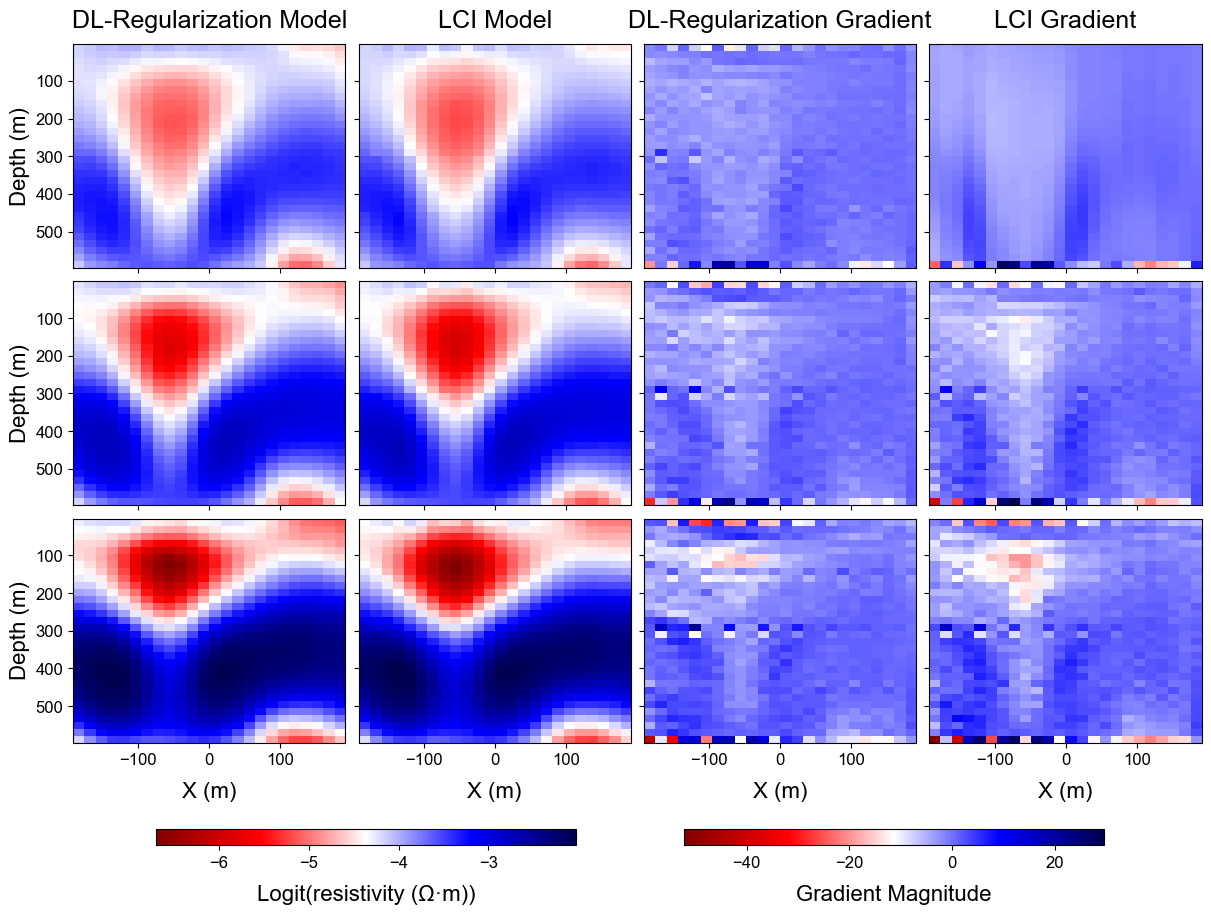

In [ ]:
grad_dl = GradientRegularization(
    nn_model=loaded_model,
    mesh=mesh_lci,
    beta=10,
    a=a,
    b=b
)
grad_lci2 = GradientRegularization_lci(
    nn_model=loaded_model,
    mesh=mesh_lci,
    beta=10,
    a=a,
    b=b
)

# Define baseline regularization
reg_0 = reglib.WeightedLeastSquares(
    mesh_lci,
    alpha_s=0.01,
    mapping=reg_map_lci,
)

# Combine regularizations
reg = grad_dl + reg_0
reg_lci2 = grad_lci2 + reg_0

# Prepare lists for smoothed and LCI models
models_smooth = [model_smooth[0], model_smooth[1], model_smooth[2]]
models_lci = [model_lci[0], model_lci[1], model_lci[2]]

gradients_smooth = []
gradients_lci = []

# Set coordinate system using mesh_lci
y_coords = np.linspace(-200, 200, 24)

# Get layer interfaces (hz[::-1]: from shallow to deep)
layer_interfaces = np.concatenate(([0], np.cumsum(hz[::-1])))
y_edges = np.linspace(y_coords[0], y_coords[-1], len(y_coords) + 1)
z_edges = layer_interfaces

# Calculate cell centers in x (horizontal) and y (vertical/depth)
x_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
y_centers = 0.5 * (z_edges[:-1] + z_edges[1:])

n_x = len(x_centers)
n_y = len(y_centers)

# Calculate gradients for both smoothed and LCI models
for ms, ml in zip(models_smooth, models_lci):
    W = grad_dl.mc_dropout_predict(ms).reshape(n_x, n_y)
    grad_smooth = W * (reg.deriv(ms).reshape(n_x, n_y))
    grad_lci_val = reg_lci2.deriv(ml).reshape(n_x, n_y)
    gradients_smooth.append(grad_smooth)
    gradients_lci.append(grad_lci_val)

import matplotlib.pyplot as plt

# Set global font to Arial
plt.rcParams['font.family'] = 'Arial'

titles = [
    "DL-Regularization Model", "LCI Model", "DL-Regularization Gradient", "LCI Gradient"
]
cmap_model = "seismic_r"
cmap_grad  = "seismic_r"

# Calculate min/max for color scales across all models/gradients
vmin = min(np.min([model.min() for model in models_smooth]), 
           np.min([model.min() for model in models_lci]))
vmax = max(np.max([model.max() for model in models_smooth]), 
           np.max([model.max() for model in models_lci]))

grad_vmin = min(np.min([g.min() for g in gradients_smooth]), 
                np.min([g.min() for g in gradients_lci]))
grad_vmax = max(np.max([g.max() for g in gradients_smooth]), 
                np.max([g.max() for g in gradients_lci]))

# Create 3x4 axes for 3 cases and 4 plots per row
fig, axes = plt.subplots(3, 4, figsize=(12, 8), constrained_layout=True)

for row in range(3):
    # --- Column 0: Smoothed Model ---
    im0 = axes[row, 0].imshow(
        models_smooth[row].reshape(n_x, n_y).T,
        extent=[x_centers[0], x_centers[-1], y_centers[0], y_centers[-1]],
        aspect="auto", origin="lower", vmin=vmin, vmax=vmax, cmap=cmap_model
    )
    axes[row, 0].set_ylabel("Depth (m)", fontsize=16, fontname='Arial')
    axes[row, 0].tick_params(axis='both', which='major', labelsize=12)
    axes[row, 0].invert_yaxis()
    for label in axes[row, 0].get_xticklabels():
        label.set_fontname('Arial')
    for label in axes[row, 0].get_yticklabels():
        label.set_fontname('Arial')
    if row == 2:
        axes[row, 0].set_xlabel("X (m)", fontsize=16, labelpad=10, fontname='Arial')
    else:
        axes[row, 0].set_xticklabels([])

    # --- Column 1: LCI Model ---
    im1 = axes[row, 1].imshow(
        models_lci[row].reshape(n_x, n_y).T,
        extent=[x_centers[0], x_centers[-1], y_centers[0], y_centers[-1]],
        aspect="auto", origin="lower", vmin=vmin, vmax=vmax, cmap=cmap_model
    )
    axes[row, 1].tick_params(axis='both', which='major', labelsize=12)
    axes[row, 1].set_yticklabels([])
    axes[row, 1].invert_yaxis()
    for label in axes[row, 1].get_xticklabels():
        label.set_fontname('Arial')
    for label in axes[row, 1].get_yticklabels():
        label.set_fontname('Arial')
    if row == 2:
        axes[row, 1].set_xlabel("X (m)", fontsize=16, labelpad=10, fontname='Arial')
    else:
        axes[row, 1].set_xticklabels([])

    # --- Column 2: Smoothed Gradient ---
    im2 = axes[row, 2].imshow(
        gradients_smooth[row].T,
        extent=[x_centers[0], x_centers[-1], y_centers[0], y_centers[-1]],
        aspect="auto", origin="lower", 
        vmin=grad_vmin, vmax=grad_vmax,
        cmap=cmap_grad
    )
    axes[row, 2].tick_params(axis='both', which='major', labelsize=12)
    axes[row, 2].set_yticklabels([])
    axes[row, 2].invert_yaxis()
    for label in axes[row, 2].get_xticklabels():
        label.set_fontname('Arial')
    for label in axes[row, 2].get_yticklabels():
        label.set_fontname('Arial')
    if row == 2:
        axes[row, 2].set_xlabel("X (m)", fontsize=16, labelpad=10, fontname='Arial')
    else:
        axes[row, 2].set_xticklabels([])

    # --- Column 3: LCI Gradient ---
    im3 = axes[row, 3].imshow(
        gradients_lci[row].T,
        extent=[x_centers[0], x_centers[-1], y_centers[0], y_centers[-1]],
        aspect="auto", origin="lower",
        vmin=grad_vmin, vmax=grad_vmax,
        cmap=cmap_grad
    )
    axes[row, 3].tick_params(axis='both', which='major', labelsize=12)
    axes[row, 3].set_yticklabels([])
    axes[row, 3].invert_yaxis()
    for label in axes[row, 3].get_xticklabels():
        label.set_fontname('Arial')
    for label in axes[row, 3].get_yticklabels():
        label.set_fontname('Arial')
    if row == 2:
        axes[row, 3].set_xlabel("X (m)", fontsize=16, labelpad=10, fontname='Arial')
    else:
        axes[row, 3].set_xticklabels([])

# Set titles for the four columns, ensure Arial font
axes[0, 0].set_title(titles[0], fontsize=18, pad=12, fontname='Arial')
axes[0, 1].set_title(titles[1], fontsize=18, pad=12, fontname='Arial')
axes[0, 2].set_title(titles[2], fontsize=18, pad=12, fontname='Arial')
axes[0, 3].set_title(titles[3], fontsize=18, pad=12, fontname='Arial')

# --- Create horizontal colorbars at the bottom ---
# Colorbar for the first two columns (model images)
cax_model = fig.add_axes([0.125, -0.05, 0.35, 0.02])  # [left, bottom, width, height]
cbar_model = fig.colorbar(im0, cax=cax_model, orientation='horizontal')
cbar_model.set_label("Logit(resistivity (Ω·m))", fontsize=16, labelpad=10, fontname='Arial')
cbar_model.ax.tick_params(labelsize=12)
for label in cbar_model.ax.get_xticklabels():
    label.set_fontname('Arial')

# Colorbar for last two columns (gradient images)
cax_grad = fig.add_axes([0.565, -0.05, 0.35, 0.02])  # [left, bottom, width, height]
cbar_grad = fig.colorbar(im2, cax=cax_grad, orientation='horizontal')
cbar_grad.set_label("Gradient Magnitude", fontsize=16, labelpad=10, fontname='Arial')
cbar_grad.ax.tick_params(labelsize=12)
for label in cbar_grad.ax.get_xticklabels():
    label.set_fontname('Arial')

plt.show()
